## Correlation Modeling 

Modeling the correlation between each pair of assets among eth,btc, and zrx.

In [7]:
import pandas as pd 
df1=pd.read_hdf('Binance_eth_btc_big.h5')
df2=pd.read_hdf('Binance_zrx_btc.h5')
df3 = pd.read_hdf('Binance_zrx_eth_big.h5')

In [26]:
#df2.head(64543),
#df2.tail(938657)
#64543,-938657

In [36]:
#df1.head(20)
#df1.tail(64540+938656-16)
#20,-1003180

In [50]:
#df3.head(1003160),df3.tail(40)
#1003160,-40

In [51]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

Setting to the same time period.

In [52]:
Close1 = df1['close'][20:-1003180]
Timestamp1 = df1['begin'][20:-1003180]
Close2 = df2['close'][64543:-938657]
Timestamp2 = df2['begin'][64543:-938657]
Close3 = df3['close'][1003160:-40]
Timestamp3 = df3['begin'][1003160:-40]


In [55]:
Timestamp=Timestamp1

In [56]:
ndays=len(Close1)//60
Close1=np.array(Close1)
Close2=np.array(Close2)
Close3=np.array(Close3)
Timestamp = np.array(Timestamp)

In [57]:
ndays,len(Close2),len(Close1),len(Close3)

(33280, 1996800, 1996800, 1996800)

In [82]:
minClose1 = np.array([Close1[60*i] for i in range(ndays)])
minClose2 = np.array([1.0/Close2[60*i] for i in range(ndays)])
minClose3 = np.array([Close3[60*i] for i in range(ndays)])
Mins = [Timestamp[60*i] for i in range(ndays)]

Exchange Rate Plots:

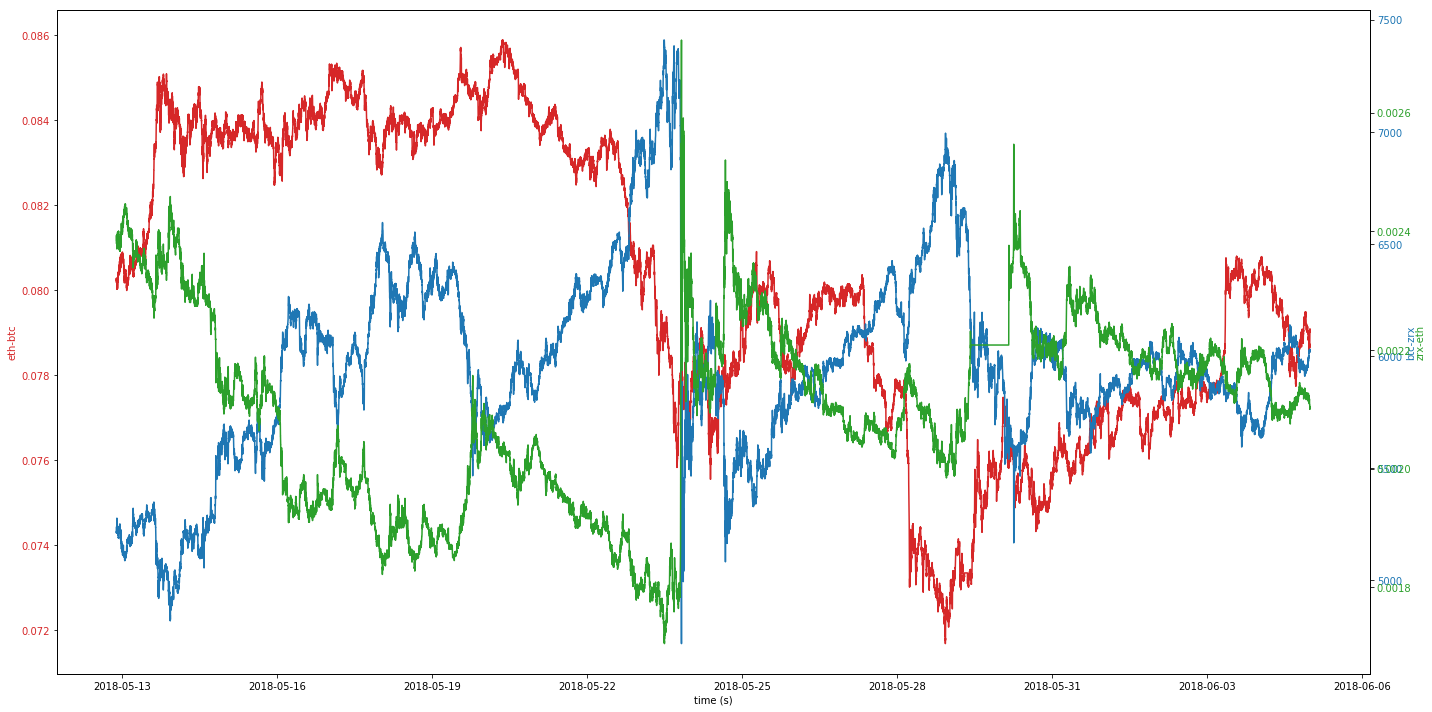

In [84]:

fig, ax1 = plt.subplots(figsize=(20,10))
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('eth-btc', color=color)
ax1.plot(Mins, minClose1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('btc-zrx', color=color)  # we already handled the x-label with ax1
ax2.plot(Mins, minClose2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax3.set_ylabel('zrx-eth', color=color)  # we already handled the x-label with ax1
ax3.plot(Mins, minClose3, color=color)
ax3.tick_params(axis='y', labelcolor=color)
fig.tight_layout() 


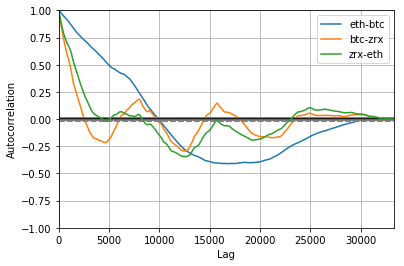

In [85]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(minClose1,label='eth-btc')
autocorrelation_plot(minClose2,label='btc-zrx')
autocorrelation_plot(minClose3,label='zrx-eth')
plt.legend()

In [86]:
minClose1=minClose1[::-1]
minClose2=minClose2[::-1]
minClose3=minClose3[::-1]
Mins = Mins[::-1]

Triangle Arbitrage Detection

Text(0.5,1,'Exchange Rate Cycle: zrx-eth * eth-btc * btc-zrx')

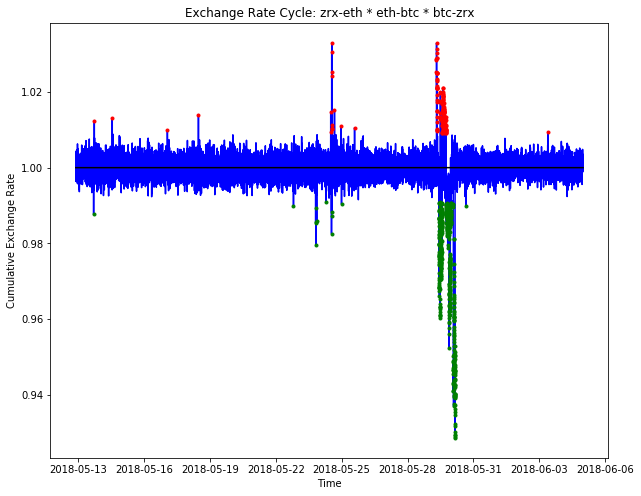

In [134]:
plt.figure(figsize=(10,8))
cycle_arbi = minClose1*minClose3*minClose2
plt.plot(Mins, cycle_arbi,c='b')
for i in range(len(Mins)):
    if cycle_arbi[i]-1>2*np.std(cycle_arbi):
        plt.plot(Mins[i],cycle_arbi[i],'ro',markersize=3)
    elif cycle_arbi[i]-1<-2*np.std(cycle_arbi):
        plt.plot(Mins[i],cycle_arbi[i],'go',markersize=3)
    else:
        pass
plt.plot(Mins, np.ones(len(Mins)),c='k')
plt.xlabel('Time')
plt.ylabel('Cumulative Exchange Rate')
plt.title('Exchange Rate Cycle: zrx-eth * eth-btc * btc-zrx')

Red dots and green dots above indicate arbitrage points with positive/negative directions.

## Correlation Modeling

In [121]:
from scipy.stats import pearsonr as corr
window = 60
C1 = np.array([corr(minClose1[i*window:i*window+window],minClose2[i*window:i*window+window])[0] for i in range(int(len(Mins)/window))])

In [122]:
C2 = np.array([corr(minClose1[i*window:i*window+window],minClose3[i*window:i*window+window])[0] for i in range(int(len(Mins)/window))])
C3 = np.array([corr(minClose3[i*window:i*window+window],minClose2[i*window:i*window+window])[0] for i in range(int(len(Mins)/window))])

Correlation Plots with the current time window:

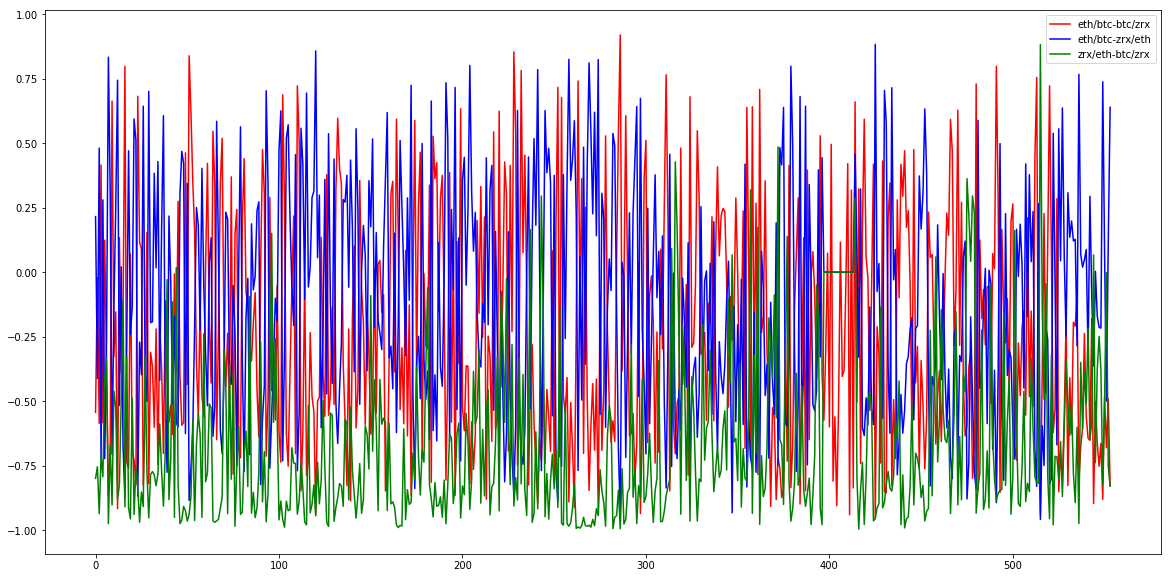

In [123]:
plt.figure(figsize=(20,10))
plt.plot(range(int(len(Mins)/window)),C1,label='eth/btc-btc/zrx',color='r')
plt.plot(range(int(len(Mins)/window)),C2,label='eth/btc-zrx/eth',color='b')
plt.plot(range(int(len(Mins)/window)),C3,label='zrx/eth-btc/zrx',color='g')
plt.legend()

Testing for mean-reversion behaviors:
    The mean reversion model for a time series X is: dX/dt = $\alpha$(m-X)+$\sigma$dW
    Here let $X_{t+1}-X_{t} = dX/dt$, a positive alpha estimate with strong confidence indicates strong mean reversion.

ETH/BTC-ZRX/ETH

In [159]:
dX = C2[1:]-C2[:-1]
X = C2[:-1].reshape(-1,1)

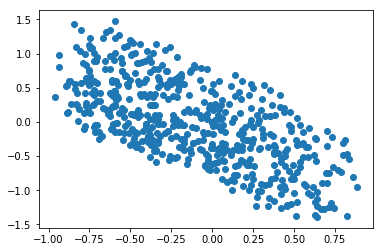

In [160]:
plt.scatter(X,dX)

In [168]:
from sklearn import datasets, linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
X = sm.add_constant(X)
regr = sm.OLS(dX,X).fit()
pred = regr.predict()
alpha=-regr.params[1]
m=regr.params[0]/alpha
sigma = np.sqrt(mean_squared_error(dX,pred))
x = X[:,1]
n=len(x)
se_a = sigma*np.sqrt(1/(sum((x-sum(x)/n)**2)))
print('Alpha:'+str(alpha))
#print('SE Alpha:'+str(se_a))
print('m:'+str(m))
# The mean squared error
print("Sigma: %.10f"
      % sigma)

Alpha:0.8838077809050565
m:-0.12236307716738609
Sigma: 0.4434159086


In [169]:
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.441
Model:                            OLS   Adj. R-squared:                  0.440
Method:                 Least Squares   F-statistic:                     434.4
Date:                Sat, 14 Jul 2018   Prob (F-statistic):           1.42e-71
Time:                        21:00:53   Log-Likelihood:                -334.95
No. Observations:                 553   AIC:                             673.9
Df Residuals:                     551   BIC:                             682.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1081      0.020     -5.518      0.000      -0.147      -0.070
x1            -0.8838      0.042    -20.843      0.000      -0.967      -0.801
==============================================================================
Omnibus:                       76.667   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.529
Skew:                           0.220   Prob(JB):                     7.78e-06
Kurtosis:                       2.090   Cond. No.                         2.29
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

ZRX/ETH-ETH/BTC

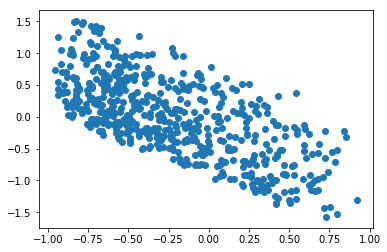

In [170]:
dX = C1[1:]-C1[:-1]
X = C1[:-1].reshape(-1,1)
plt.scatter(X,dX)

In [171]:
X = sm.add_constant(X)
regr = sm.OLS(dX,X).fit()
pred = regr.predict()
alpha=-regr.params[1]
m=regr.params[0]/alpha
sigma = np.sqrt(mean_squared_error(dX,pred))
x = X[:,1]
n=len(x)
se_a = sigma*np.sqrt(1/(sum((x-sum(x)/n)**2)))
print('Alpha:'+str(alpha))
#print('SE Alpha:'+str(se_a))
print('m:'+str(m))
# The mean squared error
print("Sigma: %.10f"
      % sigma)

Alpha:0.9448400623010212
m:-0.22811064640885695
Sigma: 0.4549630934


In [172]:
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     492.3
Date:                Sat, 14 Jul 2018   Prob (F-statistic):           2.05e-78
Time:                        21:02:02   Log-Likelihood:                -349.16
No. Observations:                 553   AIC:                             702.3
Df Residuals:                     551   BIC:                             711.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2155      0.022     -9.946      0.000      -0.258      -0.173
x1            -0.9448      0.043    -22.187      0.000      -1.028      -0.861
==============================================================================
Omnibus:                       65.403   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.908
Skew:                           0.431   Prob(JB):                     7.15e-08
Kurtosis:                       2.172   Cond. No.                         2.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

BTC/ZRX-ZRX/ETH

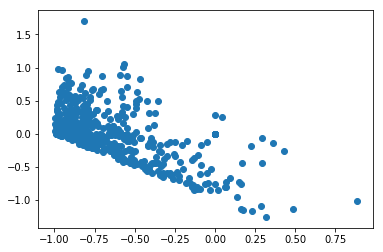

In [173]:
dX = C3[1:]-C3[:-1]
X = C3[:-1].reshape(-1,1)
plt.scatter(X,dX)

In [174]:
X = sm.add_constant(X)
regr = sm.OLS(dX,X).fit()
pred = regr.predict()
alpha=-regr.params[1]
m=regr.params[0]/alpha
sigma = np.sqrt(mean_squared_error(dX,pred))
x = X[:,1]
n=len(x)
se_a = sigma*np.sqrt(1/(sum((x-sum(x)/n)**2)))
print('Alpha:'+str(alpha))
#print('SE Alpha:'+str(se_a))
print('m:'+str(m))
# The mean squared error
print("Sigma: %.10f"
      % sigma)

Alpha:0.685082294510131
m:-0.662066891468085
Sigma: 0.3045865276


In [175]:
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.341
Method:                 Least Squares   F-statistic:                     287.0
Date:                Sat, 14 Jul 2018   Prob (F-statistic):           3.91e-52
Time:                        21:02:39   Log-Likelihood:                -127.27
No. Observations:                 553   AIC:                             258.5
Df Residuals:                     551   BIC:                             267.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4536      0.030    -15.247      0.000      -0.512      -0.395
x1            -0.6851      0.040    -16.942      0.000      -0.765      -0.606
==============================================================================
Omnibus:                      110.482   Durbin-Watson:                   2.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              194.522
Skew:                           1.179   Prob(JB):                     5.75e-43
Kurtosis:                       4.698   Cond. No.                         4.58
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These results are in support of the hypothesis that all three correlation series above are mean reverting.